In [2]:
import random
import csv
import re
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import os
from collections import Counter
import seaborn as sns

In [6]:
def find_matching_neurons(csv_path, keyword):
    matches = []
    with open(csv_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) < 2:
                continue
            neuron_id = row[0]
            if any(keyword in desc.lower() for desc in row[1:]):
                m = re.match(r"layer_(\d+)_neuron_(\d+)", neuron_id)
                if m:
                    matches.append((int(m.group(1)), int(m.group(2))))
    return matches

def count_by_first_index(data, K):
    counts = [0] * (K + 1)
    for i, _ in data:
        if 0 <= i <= K:
            counts[i] += 1
    total = len(data)
    return [c / total for c in counts]

In [7]:
def plot_neuron_distribution_grid_bar(model_paths, layer_counts, keyword_groups):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    n_rows = len(model_paths)
    n_cols = len(keyword_groups)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5.5 * n_cols, 4.5 * n_rows), sharey='row')
    plt.subplots_adjust(hspace=0.4, wspace=0.3)  # more spacing between plots

    model_names = list(model_paths.keys())
    categories = list(keyword_groups.keys())

    for i, (model_name, csv_path) in enumerate(model_paths.items()):
        max_layers = layer_counts[model_name]

        for j, (category, keywords) in enumerate(keyword_groups.items()):
            ax = axes[i][j] if n_rows > 1 else axes[j]

            # Collect data for all keywords into a single DataFrame
            plot_data = []
            for keyword in keywords:
                neurons = find_matching_neurons(csv_path, keyword)
                if not neurons:
                    continue
                layer_dist = count_by_first_index(neurons, max_layers)
                for layer, value in enumerate(layer_dist):
                    plot_data.append({
                        "Layer": layer,
                        "Frequency": value,
                        "Keyword": keyword
                    })

            df = pd.DataFrame(plot_data)
            sns.barplot(
                data=df,
                x="Layer", y="Frequency", hue="Keyword",
                ax=ax, errorbar=None
            )

            ax.set_title(f"{model_name} - {category}")
            ax.set_ylim(0, 1)
            ax.set_xlabel("Layer")
            if j == 0:
                ax.set_ylabel("Relative Frequency")
            else:
                ax.set_ylabel("")

    plt.tight_layout()
    plt.show()


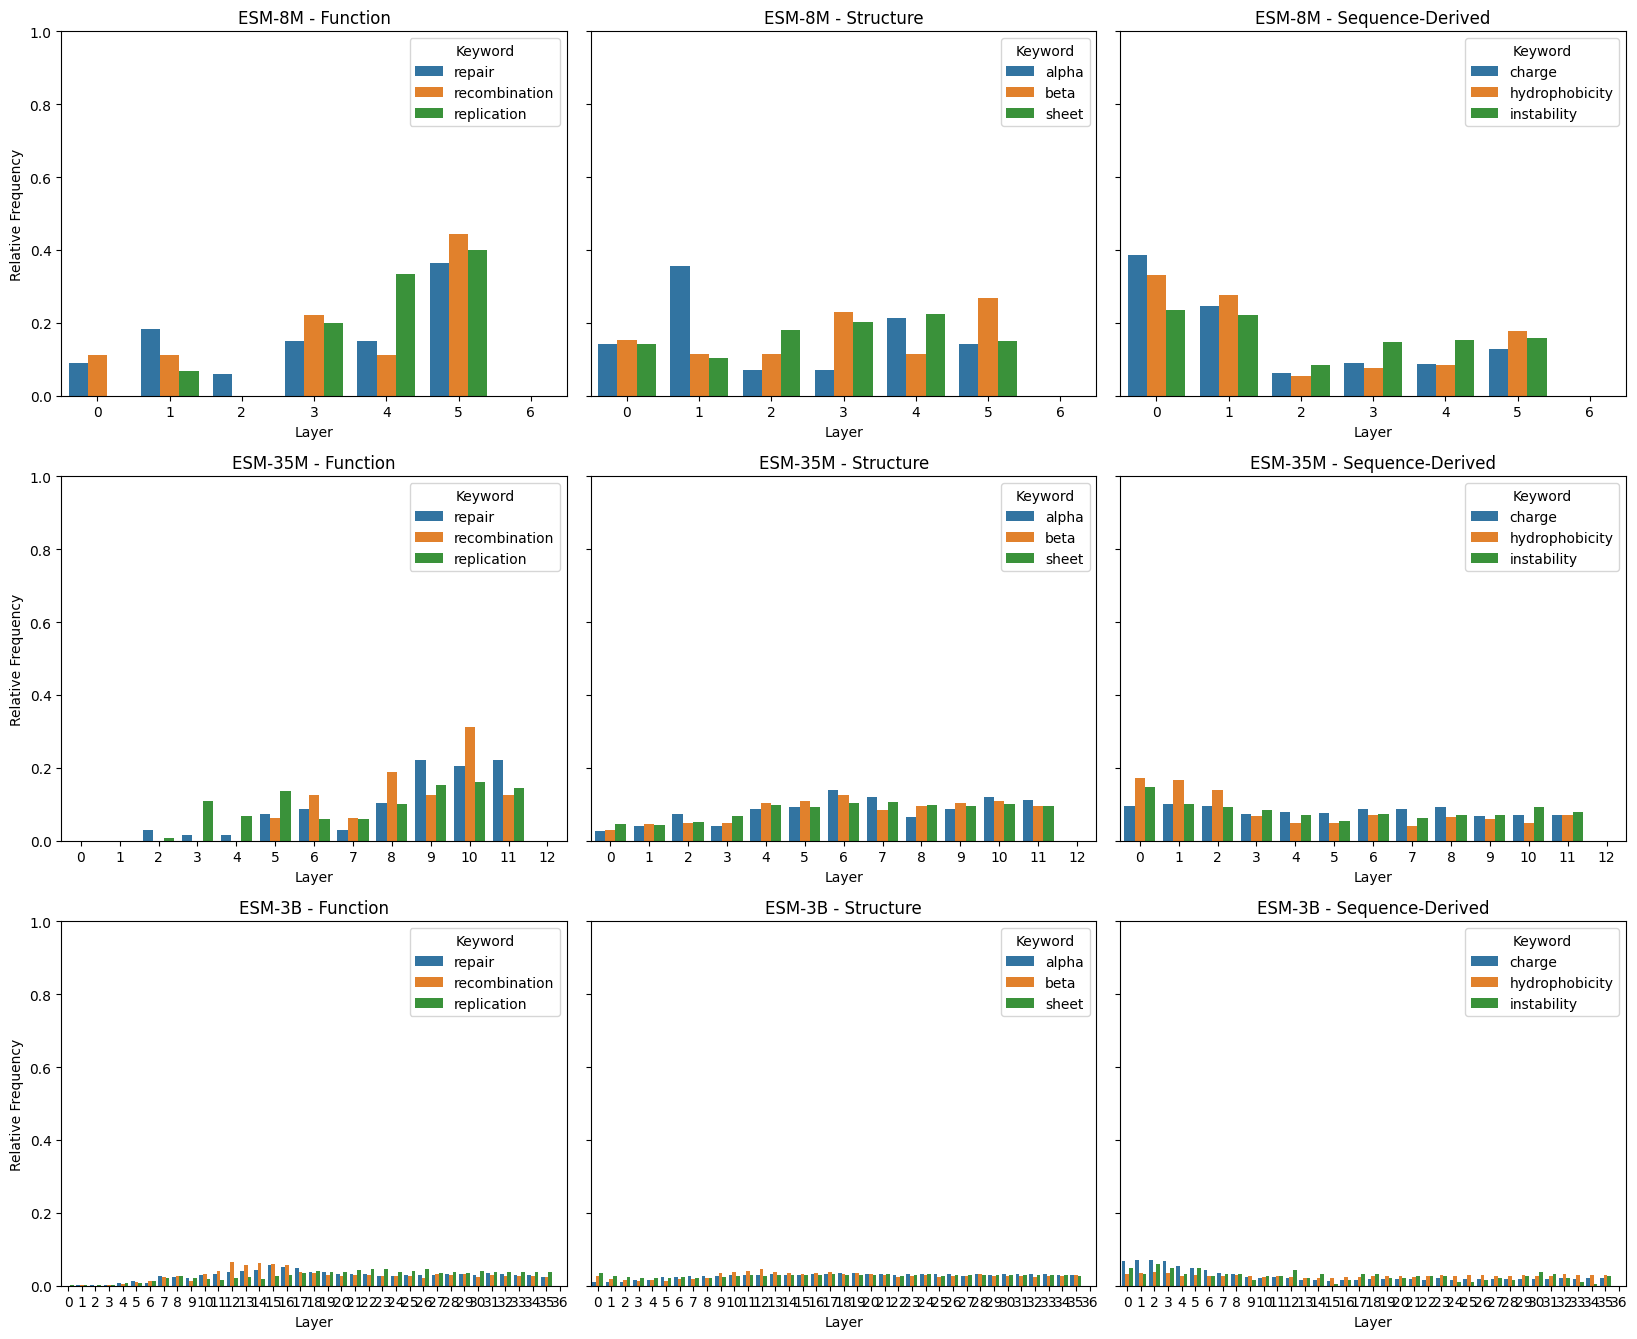

In [14]:
model_paths = {
    "ESM-8M": "../../../Downloads/esm8M_500k_neuron_explanations_final.csv",
    "ESM-35M": "../../../Downloads/esm35M_500k_neuron_explanations_final.csv",
    "ESM-3B": "../../../Downloads/esm3B_500k_neuron_explanations_redo.csv",
}

layer_counts = {
    "ESM-8M": 6,
    "ESM-35M": 12,
    "ESM-3B": 36,
}

keyword_groups = {
    "Function": ["repair", "recombination", "replication"],
    "Structure": ["alpha", "beta", "sheet"],
    "Sequence-Derived": ["charge", "hydrophobicity", "instability"],
}

plot_neuron_distribution_grid_bar(model_paths, layer_counts, keyword_groups)

In [24]:
nuerons = find_matching_neurons("../../../Downloads/esm8M_500k_neuron_explanations_final.csv", "fingers")
count_by_first_index(nuerons, 6)

ZeroDivisionError: division by zero

In [25]:
nuerons = find_matching_neurons("../../../Downloads/esm35M_500k_neuron_explanations_final.csv", "zinc fingers")
count_by_first_index(nuerons, 12)

ZeroDivisionError: division by zero

In [31]:
def plot_neuron_distribution_grid_sextile_bins(model_paths, layer_counts, keyword_groups):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np

    n_rows = len(model_paths)
    n_cols = len(keyword_groups)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5.5 * n_cols, 4.5 * n_rows), sharey='row')
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    model_names = list(model_paths.keys())
    categories = list(keyword_groups.keys())

    for i, (model_name, csv_path) in enumerate(model_paths.items()):
        max_layers = layer_counts[model_name]

        # Define bin edges (sextiles = 6 bins)
        bins = np.linspace(0, max_layers, 7, endpoint=True).astype(int)  # 6 bins = 7 edges
        bin_labels = [f"S{i+1}" for i in range(6)]

        for j, (category, keywords) in enumerate(keyword_groups.items()):
            ax = axes[i][j] if n_rows > 1 else axes[j]

            plot_data = []

            for keyword in keywords:
                neurons = find_matching_neurons(csv_path, keyword)
                if not neurons:
                    continue
                layer_dist = count_by_first_index(neurons, max_layers)

                # Bin the layer distribution into 6 bins
                binned = [0.0] * 6
                for k in range(6):
                    start = bins[k]
                    end = bins[k+1]
                    bin_avg = sum(layer_dist[start:end]) if end > start else 0
                    binned[k] = bin_avg

                for s_idx, val in enumerate(binned):
                    plot_data.append({
                        "Sextile": bin_labels[s_idx],
                        "Frequency": val,
                        "Keyword": keyword
                    })

            df = pd.DataFrame(plot_data)
            sns.barplot(
                data=df,
                x="Sextile", y="Frequency", hue="Keyword",
                ax=ax, errorbar=None
            )

            ax.set_title(f"{model_name} - {category}")
            ax.set_xlabel("Layer Sextile")
            if j == 0:
                ax.set_ylabel("Relative Frequency")
            else:
                ax.set_ylabel("")

    plt.tight_layout()
    plt.show()


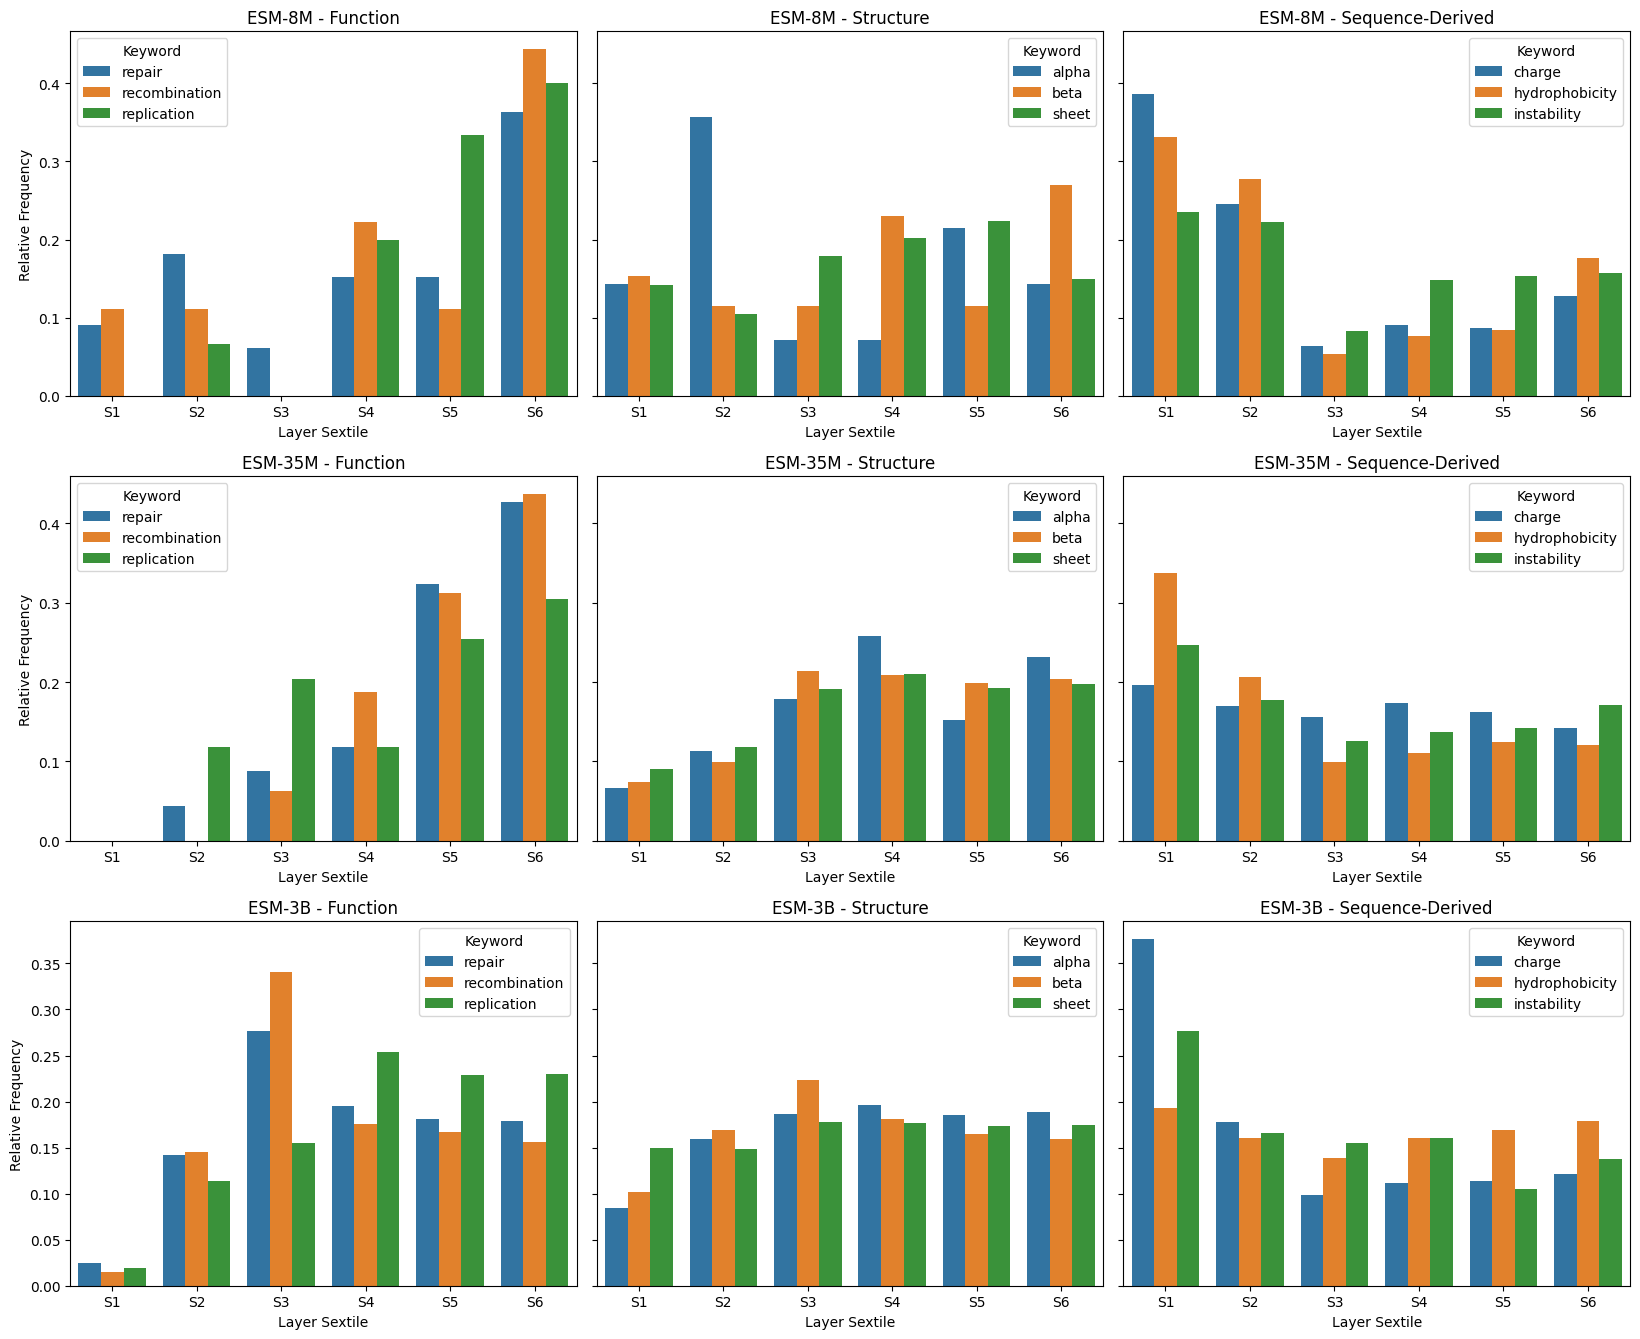

In [32]:
plot_neuron_distribution_grid_sextile_bins(model_paths, layer_counts, keyword_groups)


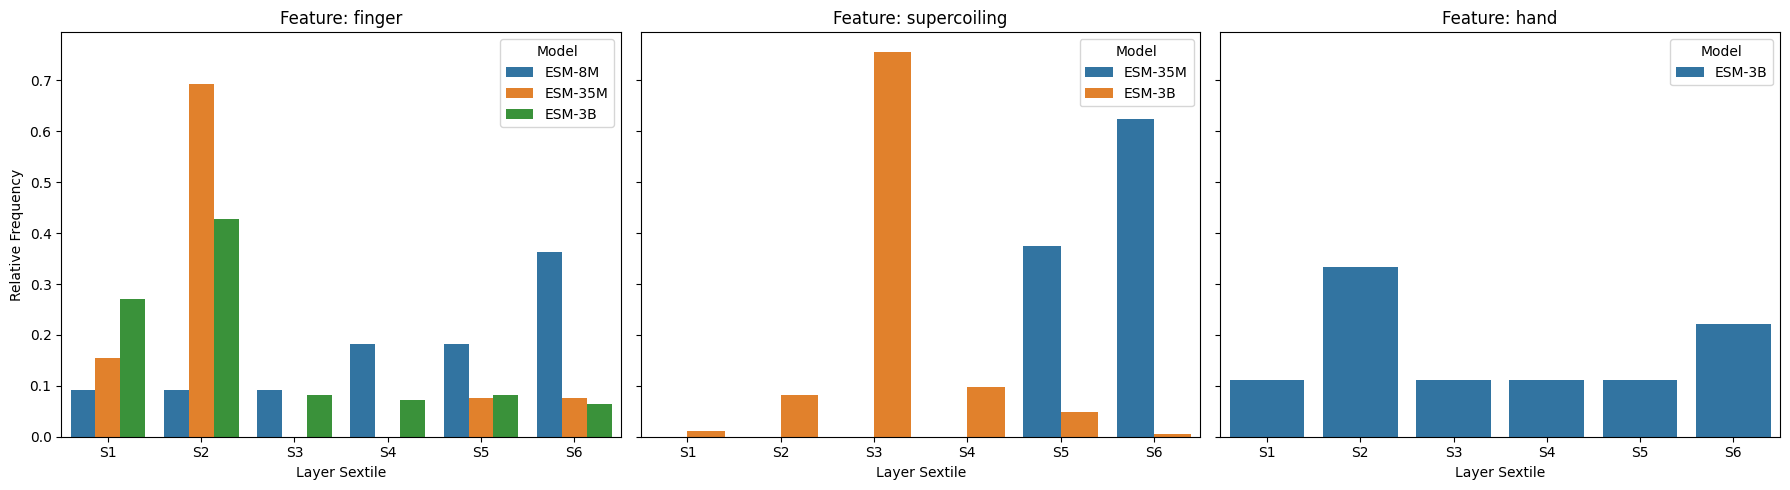

In [35]:
def plot_feature_wise_distribution(model_paths, layer_counts):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np

    features = ["finger", "supercoiling", "hand"]
    model_names = list(model_paths.keys())
    bin_labels = [f"S{i+1}" for i in range(6)]

    fig, axes = plt.subplots(1, len(features), figsize=(6 * len(features), 5), sharey=True)
    if len(features) == 1:
        axes = [axes]
    plt.subplots_adjust(wspace=0.3)

    for idx, feature in enumerate(features):
        plot_data = []

        for model_name in model_names:
            csv_path = model_paths[model_name]
            max_layers = layer_counts[model_name]
            bins = np.linspace(0, max_layers, 7, endpoint=True).astype(int)

            neurons = find_matching_neurons(csv_path, feature)
            if not neurons:
                continue

            layer_dist = count_by_first_index(neurons, max_layers)

            for k in range(6):
                start, end = bins[k], bins[k + 1]
                avg = sum(layer_dist[start:end]) if end > start else 0
                plot_data.append({
                    "Sextile": bin_labels[k],
                    "Frequency": avg,
                    "Model": model_name
                })

        df = pd.DataFrame(plot_data)
        ax = axes[idx]
        sns.barplot(data=df, x="Sextile", y="Frequency", hue="Model", ax=ax, errorbar=None)
        ax.set_title(f"Feature: {feature}")
        ax.set_xlabel("Layer Sextile")
        if idx == 0:
            ax.set_ylabel("Relative Frequency")
        else:
            ax.set_ylabel("")
        ax.legend(title="Model", loc="upper right")

    plt.tight_layout()
    plt.show()



model_paths = {
    "ESM-8M": "../../../Downloads/esm8M_500k_neuron_explanations_final.csv",
    "ESM-35M": "../../../Downloads/esm35M_500k_neuron_explanations_final.csv",
    "ESM-3B": "../../../Downloads/esm3B_500k_neuron_explanations_redo.csv",
}

layer_counts = {
    "ESM-8M": 6,
    "ESM-35M": 12,
    "ESM-3B": 36,
}

plot_feature_wise_distribution(model_paths, layer_counts)